# Salary Prediction Demo 03

In this demo, we go through the process of model training and evaluation

Bear in mind that this process is very iterative; and more than a few times insights from this stage require us to go back to earlier stages to modify the data cleaning, and feature engineering

## Imports

In [1]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn
scaler = StandardScaler()

In [4]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]

In [5]:
def _prepare_data(df, target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test

def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    map_to_values = gb[gb['count'] < r][col].values
    
    print(fr"Removing {len(map_to_values)} classes out of {len(df[col].unique())}")
    
    mapper = {k:map_to for k in map_to_values}

    return mapper, gb

In [6]:
from helper import load_data

# identify numerical columns -> those which have a distance measure
num_cols = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

# Stage 1 :  Data Preparation

## 1.1 Load Data

In [7]:
# metadata
df_meta, all_codes = load_data(r"./", verbose=False)

# cleaned dataset
df = pd.read_csv('us_census_data_cleaned.csv').drop('Unnamed: 0', axis=1)

                           U.S. DEPARTMENT OF COMMERCE
                                 BUREAU OF CENSUS                          *** DATA EXTRACTION SYSTEM ***  DOCUMENTATION OF: FILE CONTENTS  FOR DATA COLLECTION: 'pums901p' - 1990 Decenial Census 1% PUMS - Persons Records    VAR: = Variable Name
    TYP: = Variable Type     ( C = Categorical, N = Numeric Continuous )
    DES: = Designation       ( P = Primary Variable, X = Non-Primary )
    LEN: = Length            ( of the Variable in Characters )
    CAT: = Category          ( of the Variable )
VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
__________________________________________________________________________________
AAGE         C       X      1             Age Allocation Flag
                                  0       No
                                  1       YesVAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
___________________________________________________________________________

In [8]:
# provide some sensible bounds

TARGET = 'REARNING'

# exclude irrelevant data
df = df[df['AGE']      > 18]
df = df[df['AGE']      < 90]

df = df[df['REARNING'] > 5000]
df = df[df['REARNING'] < 140000]

In [9]:
# drop RSPOUSE, since MARITAL provides duplicate information
df = df.drop('RSPOUSE', axis=1)

KeyError: "['RSPOUSE'] not found in axis"

In [ ]:
# remove rare classes
mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))

In [ ]:
uninformative_columns = []
for c in df.columns:
    if len(df[c].unique()) == 1:
        print(c)
        uninformative_columns += [c]
df = df.drop(uninformative_columns, axis=1)

In [ ]:
df = df.drop(['OCCUP_JOB', 'INDUSTRY_CAT', 'PWGT1'], axis=1)

In [ ]:
print(f"Rows: {df.shape[0]} Features: {df.shape[1]}")

## 1.2 Decide on Features

In [ ]:
cats = [c for c in df.columns if c not in num_cols]

In [ ]:
print("===== FEATURE LIST ======")
for x in list(df.columns):
    
    try:
        vartype = 'NUM' if x in num_cols else 'CAT'
        if vartype == 'CAT':
            card = len(df[x].unique())
            print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
        else:
            print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
    except:
        print(x)

In [ ]:
df.head()

In [ ]:
keep_cols = [
    'REARNING',
#     'OCCUP',
#     'INDUSTRY',
    'RACE',
    'SEX',
    'HOURS',
    'AGE',
    'FERTIL',
    'WEEK89',
    'MARITAL',
    'ENGLISH',
    'YRSSERV',
    'MEANS',
    'CITIZEN',
    'YEARSCH',
    'CLASS',
    'DEPART',
    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
    'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
    
    'OCCUP_JOB',
    'OCCUP_SUM',
    'OCCUP_MAJ',
    'INDUSTRY_CAT',
    'INDUSTRY_SUM',
]

# Stage 2 : Model Exploration

Choose Metrics :

1. Score
2. Average Error in Prediction in $
3. Classification Error



### 2.1 Advanced Feature Engineering : PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(16)

In [ ]:
# df_X, _ = _prepare_data(df, 
#                     target      = TARGET, 
#                     cols        = df.columns, 
#                     cat_cols    = [c for c in keep_cols if c not in num_cols], 
#                     encode_cats = True,
#                     verbose     = False)

In [ ]:
df_X, _ = _prepare_data(df, 
                    target      = TARGET, 
                    cols        = keep_cols, 
                    cat_cols    = [c for c in keep_cols if c not in num_cols], 
                    encode_cats = True,
                    verbose     = True)

In [ ]:
# split data into inputs and outputs (truth)
# df_X = df_encoded.copy()
X_pca = np.array(df_X.drop(TARGET, axis=1), dtype=float)

# note PCA is sensitive to magnitude, so standard scaler must be applied
scaler.fit(X_pca)
X_pca = scaler.transform(X_pca)

feature_names = [x for x in list(df_X.columns) if x!=TARGET]

X_pca = pca.fit_transform(X_pca)

c=0.0
for a,b in zip(pca.get_feature_names_out(), pca.explained_variance_ratio_):
    c += b
    print(f"{a:<12} - {100*b:<6.3f} - {100*c:.3f}")

In [ ]:
for p, k in zip(pca.components_[0], [c for c in keep_cols if c != TARGET]):
    print(f"{p:<7.2f}, {k}")

## 2.1 First Attempt : Linear Model, All Data

- Linear regression is a very simple and explaianable model
- Let's use all the data

**Best Results** : $$ \$9,100 $$

### 2.1.1 First Try

Let's just fit a simple Linear Regression model to **all** the data

**Results** : $$ \$9,675 $$

In [ ]:
cols = [d for d in df.columns if d not in ['MIGSTATE', 'POWSTATE']]

df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = cols, 
                        cat_cols    = [c for c in cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows: {df_X.shape[0]} Features: {df_X.shape[1]}")

In [ ]:
# scale features so we can compare the size of the coefficients
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

### 2.1.2 Sample multiple test sets to find model error

Model training is subject to randomness and results vary; we need to know the error on the metrics to be confident in performance and to be able to determine if new experiments are better than the current best model.

Results : $$ \$9,700 +/- 35 $$

In [ ]:
results = []
coefs   = []
for i in range(10):
    print(fr"{i}/{10}", end ='\r')
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target=TARGET, 
                                                   scaler=scaler, 
                                                   shuffle=True)
    reg = LinearRegression().fit(X_train, y_train)
    coefs   += [reg.coef_]
    results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
    
err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

### 2.1.3 How do we visualize the model parameters?

Visualizing model parameters can offer insights into issues with the model (or explain some of its behaviour). Although not always possible, it is certainly possible for linear regression models

In [ ]:
xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,6))

# yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals     = np.array([xvals_[i] for i in idx])
yvals     = np.array([yvals_[i] for i in idx])
yvals_err = np.array([yvals_err_[i] for i in idx])

plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
    
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

### 2.4 More selective over columns

We can drop some of the less useful parameters to create a simpler model without losing too much accuracy

**Result** $$ \$9,700 $$

In [ ]:
idx = np.argsort(np.abs(reg.coef_))[:25]

cols = [c for c in df_X.columns if c !=TARGET]
cols = [cols[i] for i in idx]

keep_cols = [c for c in df_X.columns if c not in cols ]
keep_cols

In [ ]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]


In [ ]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

In [ ]:

xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx]
yvals = [yvals_[i] for i in idx]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[-5:][::-1]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[::-1][-5:]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

### 2.5 Technique : Use dummy variables for cats

In linear regression we encode categorical features and fit a line to them; this does not really make sense

TODO : remove rare categories from high cardinality vars

**Result** : $$ \$9,100 $$

In [ ]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART'
# ]
keep_cols

In [ ]:
dummy_cols = [k for k in keep_cols if k not in num_cols + ['OCCUP', 'ANCSTRY1', 'POWPUMA', 'RPOB','RAGECHLD']]
for k in dummy_cols:
    print(k, len(df[k].unique()))

In [ ]:

# dummy_cols = ['MARITAL', 
#               'OCCUP_SUM',
#               'INDUSTRY'
# #                'ENGLISH', 
# #                'RACE', 
# #                'OCCUP',
# #                'INDUSTRY'
#              ]



df_dummy = pd.get_dummies(df[keep_cols].iloc[:,:],
                          columns=dummy_cols, 
                          drop_first=True)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if (c not in num_cols) and (c not in dummy_cols)], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

print("======= Fitting ========")
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

In [ ]:
drop_cols = [
     'OCCUP', 
     'INDUSTRY',
     'OCCUP_JOB',
     'OCCUP_MAJ',
     'INDUSTRY_CAT',
     'ANCSTRY1',
     'ANCSTRY2',
     'RELAT1',
     'RELAT2',
     'ASERVPER',
     'AVETS1',
    
     'POB',
     'RPOB',
     'MIGPUMA',
     'POWPUMA',
     'MIGSTATE',
     'POWSTATE',
     'RAGECHLD',
    
     'LANG1',
     'LANG2',
     'ENGLISH',
    
     'RELAT2',
     'SUBFAM1',
     'SUBFAM2',
     
     'RSPOUSE',  
     'RVETSERV', # duplicate the other military categories
     'YEARSCH',  # duplicate
]

keep_cols = [d for d in df.columns if d not in drop_cols]

df_dummy = pd.get_dummies(df[keep_cols].iloc[:100000,:],
                          columns=[c for c in keep_cols if c not in num_cols], 
                          drop_first=True)
print(df_dummy.shape)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]

fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((model.coef_ > 2000) | (model.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(model.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")

## 2.2 Second Attempt : Different Model Choices

- All data, different models
- Benchmark Linear Regression

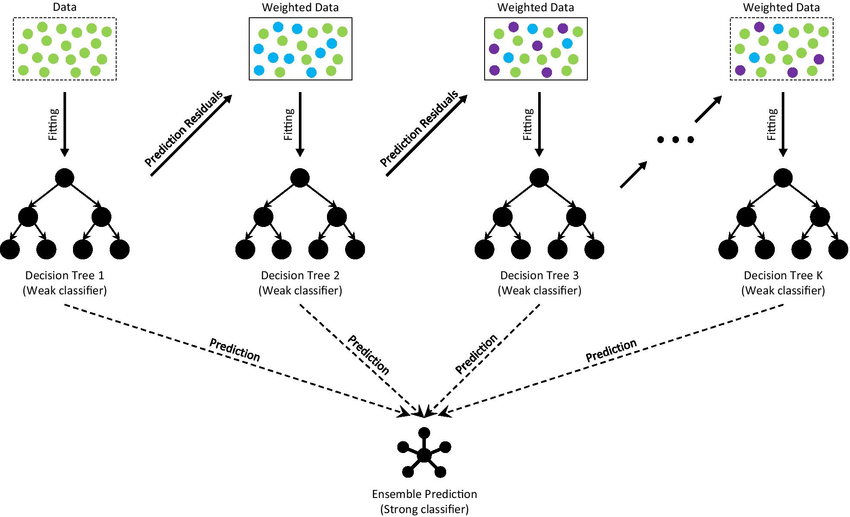

**Result** GBR : $$ \$8,700 $$

In [ ]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None, 
                        cat_cols    = [c for c in df.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

In [ ]:
# benchmark
model = LinearRegression().fit(X_train, y_train)
print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

In [ ]:
# Try and gradient boosted tree algorithm...
model = GradientBoostingRegressor(n_estimators  =100, 
                                  learning_rate =0.1,
#                                 max_depth     =5, 
                                  random_state  = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

Gradient boosted decision trees

In [ ]:
print("======= Feature Importance ========")

importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

Let's try a few more models

In [ ]:
models = []
models.append(('LR',   LinearRegression()))
models.append(('GBR',  GradientBoostingRegressor()))
models.append(('DTR',  DecisionTreeRegressor()))
models.append(('RFR',  RandomForestRegressor()))


for name, model in models:
    model.fit(X_train[:100000,:], y_train[:100000])
    print("======= Results ========")
    _ = _regression_metrics(model, X_test, y_test)

In [ ]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]

keep_cols

In [ ]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

In [ ]:
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

In [ ]:
model = GradientBoostingRegressor(n_estimators    =100, 
                                  learning_rate   =1.0,
                                  random_state    = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

In [ ]:
importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

## 2.3 Third Attempt

So far, linear regression has given a good benchmark; and is quick to train; but other types of models perform significantly better.

- We use a selected group of features
- We use boosted decision trees; as these are superior to linear regression

**Best Result** : $$ \$8,500 $$


### 2.3.1 Automated Feature Selection

In [13]:
keep_cols_0 = [
    'REARNING',
    'OCCUP']

# test_cols=[
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
#     'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
# ]

test_cols = [d for d in df.columns if d not in keep_cols_0]

keep_cols_1 = keep_cols_0

df_2 = reduce_cardinality(df, 'OCCUP', 700)

baseline = 0.0
for t in test_cols:
    print("="*80)
    print("Testing addition of ", t)
    
    keep_cols_1 += [t]
    print("Features :", keep_cols_1)
    
    tmp = [c for c in keep_cols_1 if c != TARGET]
    tmp = [True if c not in num_cols else False for c in tmp]
    
#     tmp = [c for c in keep_cols_1 if c != TARGET]
#     tmp = [True if c not in num_cols else False for c in tmp]
    
#     gb = df.groupby('OCCUP').count().sort_values('AGE')['AGE']
#     low_occup_codes = set(list(gb[gb < 100].index))
#     repl = min(low_occup_codes)

#     df_2 = df.copy()
#     # df_2 = df_2[df['OCCUP'].apply(lambda x: x not in low_occup_codes)]
#     df_2['OCCUP'] = df['OCCUP'].apply(lambda x: repl if x in low_occup_codes else x)
    
    df_X, _ = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols_1, 
                            cat_cols    = [c for c in keep_cols_1 if c not in num_cols], 
                            encode_cats = True,
                            verbose     = False)

    X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

    _regression_metrics(model, X_test, y_test)
    
    score = model.score(X_test, y_test)
    if (score - baseline) > 0.001:
        # keep
        print("Keep!")
        baseline = score
    else:
        # reject
        print("Reject!")
        keep_cols_1 = keep_cols_1[:-1]

Testing addition of  AGE
Features : ['REARNING', 'OCCUP', 'AGE']


NameError: name 'df_2' is not defined

In [ ]:
keep_cols_1

In [ ]:
[t for t in test_cols if t not in keep_cols_1]

### 2.3.1 Gradient Boosted Trees with Categorical Variables

We have introduced the same problem with cat variables to GBDTs; even though these models are naturally less sensitive.

We can use **histogram** based trees to improve on this.

Due to complexity, the maximum cardinality for histogram based trees is 255, which is less than some of our features. We thus need to reduce the cardinality. We can do this by gathering all uncommon classes into a single "other" category.

**Result** : $$ \$8,500 $$

In [ ]:
def reduce_cardinality(df, feature='OCCUP', group_below=700):
    
    gb = df.groupby(feature).count().sort_values('AGE')['AGE']
    
    print(f"Old cardinality {gb.shape[0]}")

    low_occup_codes = set(list(gb[gb < group_below].index))
    repl = min(low_occup_codes)

    df_2 = df.copy()
    df_2[feature] = df[feature].apply(lambda x: repl if x in low_occup_codes else x)
    
    print(f"New cardinality {len(df_2[feature].unique())}")
    
    return df_2

In [ ]:
df_2 = reduce_cardinality(df, 'OCCUP', 700 )

In [ ]:
cat_cols = [c for c in keep_cols if c not in num_cols]

tmp = [c for c in keep_cols if c != TARGET]
tmp = [True if c not in num_cols else False for c in tmp]

df_X, lecs = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols, 
                            cat_cols    = cat_cols, # [c for c in df_2.columns if c not in num_cols],# 
                            encode_cats = True,
                            verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

In [ ]:
model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

In [ ]:
_ = _regression_metrics(model, X_test, y_test)

In [ ]:
# train N times
results = []

for i in range(10):
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target  = TARGET, 
                                                   scaler  = None, 
                                                   shuffle = True)
    
    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)
    results += [_regression_metrics(model, X_test, y_test)]

err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

##  2.4 Model Tuning

Now we have selected a good model; we can tune the performance by adjusting the **hyperparameters**

**Best Result** : $$ \$8,400 $$

In [ ]:
# baseline = no tuning
model = HistGradientBoostingRegressor(max_bins=255,
                                      categorical_features=tmp).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

In [ ]:
results = []

for lr in np.linspace(0.005,0.25,25):
    print(lr)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=lr,
                                     max_bins=255,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res] #model.score(X_test, y_test)]

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(np.linspace(0.005,0.25,25), [r['score'] for r in results])
ax[1].plot(np.linspace(0.005,0.25,25), [r['mean_abs_err'] for r in results])
ax[1].plot([0,0.25],[8500,8500], color='r', ls=":")
plt.yscale('log')

In [ ]:
results = []

for v in np.linspace(10,250,25):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate       =0.25,
                                     max_bins            =255,
                                     max_iter            = int(v),
                                     categorical_features=tmp,
                                     random_state        =0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(np.linspace(10,250,25), [r['score'] for r in results])
ax[1].plot(np.linspace(10,250,25), [r['mean_abs_err'] for r in results])
ax[1].plot([10,250],[8500,8500], color='r', ls=":")
plt.yscale('log')

In [ ]:
results = []

for v in range(1,10,1):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate = 0.25,
                                     max_bins      = 255,
                                     max_depth     = v,
                                     max_iter      = 200,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(1,10,1), [r['score'] for r in results])
ax[1].plot(range(1,10,1), [r['mean_abs_err'] for r in results])
ax[1].plot([0,10],[8500,8500], color='r', ls=":")
plt.yscale('log')

# Stage 3 :  Model Testing

- We provided some basic metrics, but can we look deeper
- Use our best model and best parameter set (after tuning)

In [10]:
import lime
import lime.lime_tabular

In [11]:
model = HistGradientBoostingRegressor( 
                                     learning_rate= 0.25,
                                     max_bins     = 255,
                                     max_depth    = 9,
                                     max_iter     = 200,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

NameError: name 'tmp' is not defined

In [14]:
feature_names = [x for x in list(df_X.columns) if x!=TARGET]

explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train, 
   feature_names       = feature_names, 
   categorical_features= [i for i, x in enumerate(feature_names) if x in cats], 
   verbose             = True, 
   mode                = 'regression')

NameError: name 'df_X' is not defined

In [15]:
i = 0

xi,yi = X_test[i], y_test[i]
exp   = explainer.explain_instance(xi, 
                                 model.predict, 
                                 num_features=8)
exp.show_in_notebook(show_table=True)

NameError: name 'X_test' is not defined

## 3.2 Variational Testing

In [16]:
# extract a dictionary input
features = [c for c in df_2.columns if c != TARGET] # [c for c in keep_cols if c != TARGET]
assert len(features) == X_train.shape[1]
xi = {k:i for k,i in zip(features, X_train[4])}

xi_inv = xi.copy()
for k,v in xi.items():
    if k in lecs:
        xi_inv[k] = lecs[k].inverse_transform([int(v)])[0]
xi_inv

NameError: name 'df_2' is not defined

In [17]:
def _predict_from_dict(model, xi, encoders: dict, scaler=None):
    
    categorical_vars = list(encoders.keys())
    
    for feature in categorical_vars:
        xi[feature] = encoders[feature].transform(np.array(xi[feature]).reshape(1,))[0]
    
    labels = list(xi.keys())
    
    if scaler:
        xi = scaler.transform(pd.DataFrame(np.array(list(xi.values())).reshape(1,-1), 
                                           columns=xi.keys()))  
    else:
        xi = np.array(list(xi.values())).reshape(1,-1)
    
#     xi = pd.DataFrame(xi, columns=labels)
    
    ri = model.predict(xi)

    return ri

In [18]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE': 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

_predict_from_dict(model, xi.copy(), lecs)

NameError: name 'model' is not defined

In [19]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE' : 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="b")

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="g")

plt.plot([25,70], [0.5,0.5], color="black", ls=":")
# plt.ylim([0.25,0.75])

NameError: name 'model' is not defined

In [ ]:
xi = {'OCCUP'  : 8.0,
     'INDUSTRY': 641.0,
     'RACE'    : 'White 800 869, 971',
     'SEX'     : 0.0,
     'HOURS'   : 99.0,
     'AGE'     : 50.0,
     'FERTIL'  : 0.0,
     'WEEK89'  : 52.0,
     'MARITAL' : 0.0,
     'ENGLISH' : 2.0,
     'YRSSERV' : 0.0,
     'MEANS'   : 1.0,
     'CITIZEN' : 1.0,
     'YEARSCH' : 15.0,
     'CLASS'   : 6.0,
     'DEPART'  : 530.0}

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="g")

plt.plot([18,90], [0.5,0.5], color="black", ls=":")
plt.grid()
# plt.ylim([0.25,0.75])

In [ ]:
df_X['OCCUP'].unique()

# Bonus : Deep Learning

- We started simple according to our own rules; but we can now see if deep learning can do better.

- MLP is the appropriate architecture (it is also the simplest)
- We denseley connect all neurons so complex relationships between any two variables can be built
- The dataset size does not justify large models, and we prefer shallow, wide networks

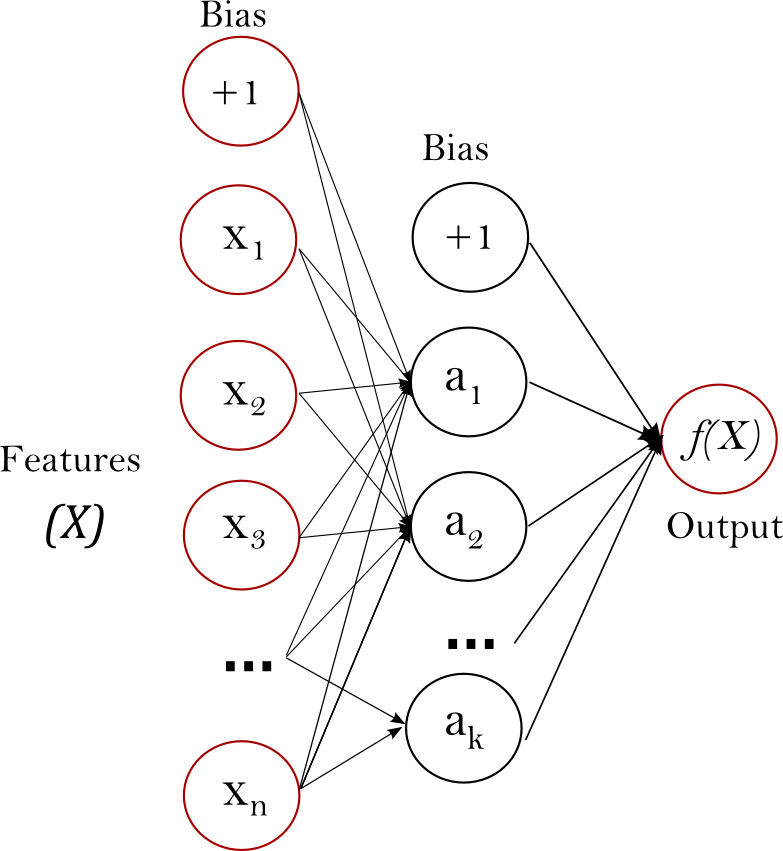

As it turns out, deep learning can achieve good performance but not best without tuning. The expense of the training procedure and the size of the model (and explainability) both count against DL and make something simpler a much better option for this problem.

**Why DL didn't have bets performance**
- Small dataset size
- Mostly linear relationships, don't need DL complexity
- Lack of DL tuning

In [20]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [21]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None,
                        cat_cols    = [c for c in df.columns if c not in num_cols],
                        encode_cats = True,
                        verbose     = True)

X_train, y_train, X_test, y_test = _split_data(df_X, 
                                               target=TARGET, 
                                               scaler=None)


Cardinalities
ANCSTRY1                  : 229
ANCSTRY2                  : 157
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 4
FEB55                     : 2
HISPANIC                  : 52
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 494
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 251
POWPUMA                   : 105
POWSTATE                  : 52
RACE                      : 62
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SCHOOL                    : 3
SEPT80                    : 2
SEX

In [22]:
# clf = MLPClassifier(random_state=1, 
#                     max_iter    =300,
#                     verbose     =True).fit(X_train, y_train)

In [23]:
# prove we can overfit to the solution
clf = MLPRegressor(
    hidden_layer_sizes = (X_train.shape[1]+1,10),
    random_state       = 1, 
    max_iter           = 10,
    learning_rate_init = 0.001,
    verbose            = True).fit(np.concatenate((X_train, y_train.reshape((-1,1))), axis=1), y_train)

Iteration 1, loss = 15673239.82212359
Iteration 2, loss = 286.58656167
Iteration 3, loss = 6.61763863
Iteration 4, loss = 3.48663466
Iteration 5, loss = 10.79653046
Iteration 6, loss = 17.26159466
Iteration 7, loss = 14.44976718
Iteration 8, loss = 7.59248666
Iteration 9, loss = 14.71204680
Iteration 10, loss = 11.16767038


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test  = scaler.transform(X_test)

In [25]:
clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],
                                    X_train.shape[1],
                                    X_train.shape[1]),
                random_state      = 1, 
                max_iter          = 300,
                learning_rate_init= 0.001,
                verbose           = False)

for i in range(100):
    clf.partial_fit(X_train, y_train)
    print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$10397.68
$9489.92
$9212.04
$9056.56
$8971.82
$8918.62
$8886.56
$8856.68
$8826.30
$8799.41
$8778.70
$8761.54
$8748.66
$8732.51
$8712.37
$8701.08
$8691.62
$8677.20
$8671.08
$8663.71
$8653.32
$8639.10
$8633.86
$8624.52
$8614.10
$8601.12
$8586.50
$8589.69
$8580.09
$8567.35
$8557.80
$8556.55
$8547.58
$8543.49
$8532.33
$8541.60
$8540.63
$8530.14
$8523.76
$8523.05
$8510.19
$8509.41
$8502.77
$8499.18
$8499.92
$8492.59
$8481.78
$8470.30
$8468.77
$8463.71
$8464.10
$8449.48
$8442.71
$8445.27
$8429.50
$8426.53
$8421.48
$8410.01
$8403.39
$8395.29
$8383.03
$8385.57
$8381.99
$8372.68
$8364.94
$8356.90
$8347.71
$8355.69
$8338.90
$8332.28
$8327.28
$8327.46
$8321.81
$8322.84
$8305.21
$8306.27
$8301.53
$8295.09
$8296.00
$8299.72
$8304.09
$8292.76
$8287.49
$8297.89
$8285.58
$8275.87
$8267.82
$8265.78
$8260.00
$8263.56
$8251.49
$8264.82
$8267.72
$8265.02
$8248.72
$8257.55
$8244.64
$8245.50
$8231.23
$8235.42


In [26]:
clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],
                                    X_train.shape[1],
                                    X_train.shape[1]),
                random_state      = 1, 
                max_iter          = 300,
                learning_rate_init= 0.01,
                verbose           = False)

for i in range(100):
    clf.partial_fit(X_train, y_train)
    print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

$9654.68
$8841.27
$8773.45
$8762.60
$8742.96
$8759.84
$8745.02
$8720.98
$8749.91
$8810.86
$8809.26
$8888.80
$8879.38
$8852.72
$8853.01
$9011.38
$8876.34
$8931.47
$8899.68
$8837.91
$8876.54
$8934.27
$8924.98
$8948.63
$8918.42
$9020.01
$8904.80
$9010.46
$8971.98
$8968.00
$8970.97
$8966.76
$8936.39
$9002.76
$8954.93
$8956.80
$8962.04
$8966.88
$8922.40
$8892.03
$8969.64
$8981.45
$8973.10
$8923.47
$8868.87
$8854.36
$8847.84
$8810.16
$8781.08
$8764.33
$8707.56
$8801.83
$8693.01
$8652.44
$8647.17
$8617.46
$8557.13
$8572.48
$8593.19
$8506.83
$8442.08
$8471.18
$8382.69
$8371.86
$8483.68
$8408.45
$8459.83
$8410.24
$8398.69
$8430.68
$8375.95
$8379.49
$8376.99
$8389.05
$8321.13
$8281.89
$8314.94
$8298.12
$8318.31
$8313.69
$8342.48
$8321.08
$8329.52
$8286.64
$8309.47
$8302.48
$8369.77
$8331.08
$8306.30
$8244.99
$8270.60
$8287.02
$8230.07
$8297.85
$8234.73
$8257.69
$8217.24
$8254.42
$8255.06
$8255.93


In [27]:
# # clf = MLPRegressor(
# #     hidden_layer_sizes=(60,30),
# #     random_state=1, 
# #     max_iter=300,
# #     learning_rate_init=0.01,
# #     verbose=True).fit(X_train, y_train)

# clf = MLPRegressor(
#                 hidden_layer_sizes=(X_train.shape[1],X_train.shape[1],X_train.shape[1]),
#                 random_state=1, 
#                 max_iter=300,
#                 learning_rate_init=0.01,
#                 verbose=False)

# for i in range(100):
#     clf.partial_fit(X_train, y_train)
#     print(f"${np.abs(clf.predict(X_test) - y_test).mean():.2f}")

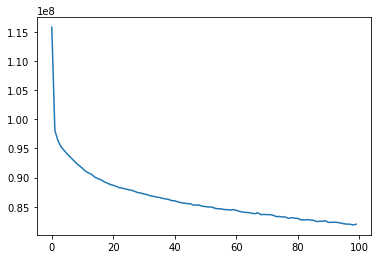

In [28]:
plt.plot(clf.loss_curve_)

In [29]:
# lowest loss 82M (60)
# next (60,60) -> 75M, worse test loss

In [30]:
np.abs(clf.predict(X_test) - y_test).mean()

8255.933390083286